### Import all relevant dependencies

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pathlib import Path
from oed.experiments.experiment_library.latin_hypercube import LatinHypercube
from src.experiments.experiment_library.fcs_a_design import FCSADesign
from src.experiments.experiment_library.fcs_d_design import FCSDDesign
from src.experiments.experiment_library.fcs_pi_design import FCSPiDesign
from src.math_utils.blackbox_evaluation import evaluate_blackbox_region
from src.minimizer.minimizer_library.cmaes import CMAESMinimizer
from src.minimizer.minimizer_library.differential_evolution_parallel import DifferentialEvolutionParallel
from src.minimizer.minimizer_library.shgo import SHGO
from src.statistical_models.statistical_model_library.fcs_gaussian_noise_model import FCSGaussianNoiseModel
from src.utils.experiment_serialization import save_experiment_results
from src.visualization.plotting_functions import *
from src.math_utils.experiment_metrics import calculate_experiment_metrics, calculate_estimator_metrics
from src.math_utils.derivatives.numeric_derivative_calculator import NumericDerivativeCalculator
from src.model.hahn_stack_model import HahnStackModel
from src.math_utils.scaler.hahn_parameter_scaler import HahnParameterScaler
from src.model.parameter_set.zsw_data_parameter_set import HahnParameterSet

### Define the Experiment Metadata
- bounds for the free parameters
- operating conditions
- experiment repetitions
- true parameter set
- Experiment variance
- current values

In [2]:
number_designs = 25  #Amount of LH Designs
n_rep = 100  #Amount of experiment repetitions
n_current_values = 10  #Amount of indivdual current values
sigma = 0.01 #experiment variance (10mV variance in repeated experiments)

# lower and upper bounds for operating conditions
upper_bounds_operating_conditions = np.array([350000,  # p.Si.A [Pa] # Hydrogen pressure anode [Pa]
                                              95 + 273.15,  # T.So.CL [K] stack temperature [K]
                                              3.5,  # Stoic.Si.C [-]
                                              ])

lower_bounds_operating_conditions = np.array([130000,  # p.Si.A [Pa]
                                              45 + 273.15,  # T.So.CL [K] stack temperature [K]
                                              1.3,  # Stoic.Si.C [-]
                                              ])

I_S_array = np.linspace(1, 480, n_current_values)  # initialize applicable current array request

# initialize applicable parameter set
unscaled_theta_true = np.array(list(HahnParameterSet().free_parameters.values())[:4])
names_theta = list(HahnParameterSet().free_parameters.keys())[:4]

# initialize lower and upper bounds for free parameter values
unscaled_upper_bounds_free_params = np.array([
    100000,  # E_A
    500,  # j_0_ref
    10,  # f_CL
    5e-5,  # r_el
])

unscaled_lower_bounds_free_params = np.array([
    1000,  # E_A
    0.01,  # j_0_ref
    1e-1,  # f_CL
    5e-7,  # r_el
])

print(names_theta, unscaled_lower_bounds_free_params, unscaled_theta_true, unscaled_upper_bounds_free_params)


['E_A', 'j_0_ref', 'f_CL', 'r_el'] [1.e+03 1.e-02 1.e-01 5.e-07] [6.0e+04 5.3e+01 8.6e-01 6.6e-06] [1.e+05 5.e+02 1.e+01 5.e-05]


### Define Scaler and scale parameter values as well as  bounds of operating conditions and parameters
Scalers are saved in variable "scaler" and handed over to stack model.

In [3]:
scaler = HahnParameterScaler() # define scaler

# Stack bounds of free parameters
free_parameter_bounds = np.vstack([
    unscaled_lower_bounds_free_params,
    unscaled_upper_bounds_free_params
]).T

# Stack operating condition bounds (rows = condition, columns = [min, max])
operating_condition_bounds = np.vstack([
    lower_bounds_operating_conditions,
    upper_bounds_operating_conditions
]).T

# Determine current range for scaling
current_bounds = np.array([[I_S_array.min(), I_S_array.max()]])

scaled_theta_true = scaler.scale_theta(unscaled_theta_true, free_parameter_bounds)

# scale bounds of operating conditions to hand over for Experimental designs incl. LHC
scaled_upper_bounds = scaler.scale_params(upper_bounds_operating_conditions, operating_condition_bounds)
scaled_lower_bounds = scaler.scale_params(lower_bounds_operating_conditions, operating_condition_bounds)

# scale bounds of free parameters for initializing Model
scaled_lower_bounds_theta, _ = scaler.scale(unscaled_lower_bounds_free_params, free_parameter_bounds)
scaled_upper_bounds_theta, _ = scaler.scale(unscaled_upper_bounds_free_params, free_parameter_bounds)

# Print scaling results of scaled true parameters
print("Scaled theta:", scaled_theta_true)
print("Rescaled theta:", unscaled_theta_true)

Scaled theta: [0.5959596  0.10598212 0.07676768 0.12323232]
Rescaled theta: [6.0e+04 5.3e+01 8.6e-01 6.6e-06]


### Define the parametric function including handover of bounds

In [4]:
hahn_fc_model = HahnStackModel(parameter_set=HahnParameterSet()) #Instanciallize the generic Hahn Model
calculator = NumericDerivativeCalculator(hahn_fc_model, scaler) # instanciallize the derivation calculator function

# Initiallize statistical model function
statistical_model = FCSGaussianNoiseModel(model_function=hahn_fc_model,
                                          der_function=calculator,
                                          lower_bounds_x=scaled_lower_bounds,
                                          upper_bounds_x=scaled_upper_bounds,
                                          lower_bounds_theta=scaled_lower_bounds_theta,
                                          upper_bounds_theta=scaled_upper_bounds_theta,
                                          sigma=sigma,
                                          scaler = scaler,)

# initialize blackbox function returning noised experiment results
def blackbox_model(x):
    return statistical_model.random(theta=scaled_theta_true, x=x)

### Calculate LH Designs
returns LH Object to be used in other experimental design calculations

In [5]:
LH = LatinHypercube(lower_bounds_design=lower_bounds_operating_conditions,
                    upper_bounds_design=upper_bounds_operating_conditions,
                    number_designs=number_designs)

print(LH.experiment)

[[1.48897295e+05 3.64742426e+02 1.36737548e+00]
 [1.76965030e+05 3.38585444e+02 2.12106946e+00]
 [3.11466556e+05 3.25944876e+02 2.81444575e+00]
 [1.62722708e+05 3.20220381e+02 2.70560955e+00]
 [2.71507517e+05 3.42122414e+02 2.57796858e+00]
 [2.11174318e+05 3.61055872e+02 2.77402630e+00]
 [2.18498939e+05 3.50970167e+02 3.23898316e+00]
 [2.94515885e+05 3.36804154e+02 1.79626630e+00]
 [2.41251790e+05 3.30247200e+02 1.59913738e+00]
 [2.49452567e+05 3.32920427e+02 1.47345769e+00]
 [2.04646813e+05 3.27052978e+02 1.71020299e+00]
 [2.80881070e+05 3.43625059e+02 3.47276469e+00]
 [3.43984463e+05 3.62233950e+02 2.28756415e+00]
 [1.94646709e+05 3.52235947e+02 2.91551452e+00]
 [1.72128139e+05 3.29775059e+02 2.43004957e+00]
 [3.32117687e+05 3.49021787e+02 3.14725550e+00]
 [1.35734428e+05 3.34680677e+02 3.39433891e+00]
 [1.87813840e+05 3.24030585e+02 2.00764720e+00]
 [2.66218947e+05 3.18781478e+02 3.03391078e+00]
 [3.02086088e+05 3.54997712e+02 1.86400404e+00]
 [3.35375550e+05 3.66869369e+02 2.214938

### Evaluate Cell Voltage for LH-Designs with repetitions
Execute Experimental designs from LH experiments.


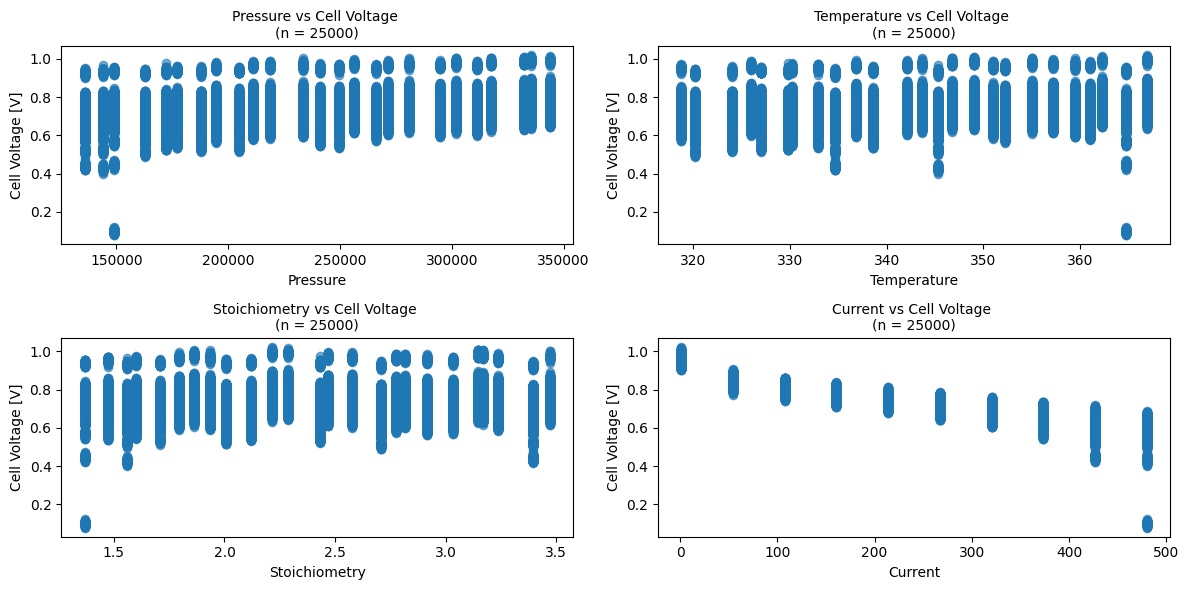

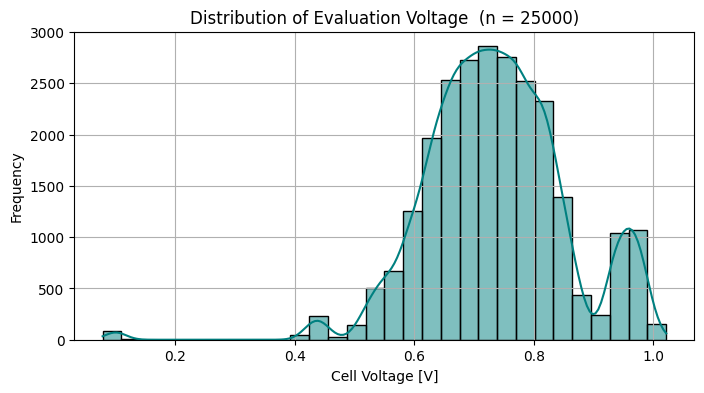

In [6]:
# Experiment execution with Current request and noised repetitions, returning y = calculated cell voltages, and x = full array of experiments incl. current values. Len of the returned array is number_designs * n_current_values * n_rep
evaluation_LH_experiment, x_LH_design = evaluate_blackbox_region(blackbox_model, LH.experiment, I_S_array, repetitions=n_rep)

# Plot results form experiment evaluation
plot_blackbox_evaluation(x_LH_design, evaluation_LH_experiment, input_labels=["Pressure", "Temperature", "Stoichiometry", "Current"])

### calculate and plot metrics of LH-Designs
calculates different kinds of metrics and prints them out directly for analysis.

In [7]:
# return array of operating conditions with number_designs * n_current_values
_, x0_LH_design = evaluate_blackbox_region(blackbox_model, LH.experiment, I_S_array)

# calculate experiment metrics
(FIM_LH_experiment,
 det_FIM_LH_experiment,
 diagonal_CRLB_LH_experiment,
 CRLB_LH_experiment,
 std_LH_Experiment) = calculate_experiment_metrics(statistical_model, scaled_theta_true, x0_LH_design)

# print experiment metrics
print(f"total amount of LH designs with current and repetitions: {len(x_LH_design)}") # number_designs * n_current_values * n_rep, just to double check
print(f"total amount of LH designs with current: {len(x0_LH_design)}") # number_designs * n_current_values, just to double check
print(f"FIM LH experiment:\n {FIM_LH_experiment}")
print(f"determinant of FIM:\n {det_FIM_LH_experiment}")
print("CRLB of Latin Hypercube experiment at initial theta: \n",
      diagonal_CRLB_LH_experiment)
print('The relative expected standard deviations of the LH estimators are \n',
      std_LH_Experiment)

total amount of LH designs with current and repetitions: 25000
total amount of LH designs with current: 250
FIM LH experiment:
 [[   5330.50063252  -16471.79785644   -1840.21634549   33905.10348689]
 [ -16471.79785644  145766.47692598   13871.6852141  -297644.01826746]
 [  -1840.21634549   13871.6852141     3352.40040369  -43867.22430927]
 [  33905.10348689 -297644.01826746  -43867.22430927  853840.24186198]]
determinant of FIM:
 1.283849534531836e+17
CRLB of Latin Hypercube experiment at initial theta: 
 [2.93539747e-04 2.90471677e-05 9.69163016e-04 7.92055227e-06]
The relative expected standard deviations of the LH estimators are 
 [0.0287486  0.05085332 0.40552723 0.02283774]


### Save LH-Designs as CSV

In [8]:
x_array = np.array(x_LH_design)
eval_array = np.array(evaluation_LH_experiment).reshape(-1, 1)  # Reshape to (N, 1)
# Concatenate x & y column-wise --> save all experiments with repetitions and evaluations
combined_array = np.hstack((x_array, eval_array))

root = Path.cwd().parent   # this will be oed_fuel_cell_model/
data_path = root / "data" / "experimental_designs" / "lhc"
data_path.mkdir(parents=True, exist_ok=True)

save_experiment_results(combined_array, data_path / f"lhc.csv")

25000
Experiment results saved to C:\projects\MOO-FCS\ma\oed_fuel_cell_model\data\experimental_designs\lhc\lhc.csv


### Initialize minimizer and hyperparameters for additional experiments

In [9]:
parameter_index = 2 # individual parameter from parameterset that shall be evaluated in the Pi-Design
number_new_designs = 5 # number of new designs
iterations = 100 # maximum iterations of minimizer function

minimizer = DifferentialEvolutionParallel(maxiter=iterations, n_workers=-1)

In [ ]:
# Estimate thetas, estimated are for every experiment setup with all current values one theta, so n_theta_estimations = n_rep
scaled_estimated_thetas = statistical_model.estimate_repeated_thetas(
    x0=x_LH_design, y=evaluation_LH_experiment, n=n_rep, minimizer=minimizer)

Estimating thetas:   7%|▋         | 7/100 [11:16<2:27:48, 95.36s/it] 

In [ ]:
# calculate metrics and mean theta value
estimated_theta, var_theta, rel_error, rel_std = calculate_estimator_metrics(scaled_estimated_thetas, scaled_theta_true, diagonal_CRLB_LH_experiment)
print('The estimated Theta mean for all estimations is \n', estimated_theta)
print('The relative expected standard deviations of the true parameters from the LH designs are \n', rel_std)
print('The relative error of the parameter estimations from the LH designs are \n', rel_error)
print('The variance of the estimations of the parameters from the LH designs are \n', var_theta)


### Initialize and execute calculation of different experimental designs

In [ ]:
# calculate additional LHC Experiments
LH_new = LatinHypercube(lower_bounds_design=lower_bounds_operating_conditions,
                        upper_bounds_design=upper_bounds_operating_conditions,
                        number_designs=number_new_designs)

print(LH_new.experiment)

In [ ]:
# calculate additional Pi-Designs under estimated theta and the chosen parameter index
pi_design = FCSPiDesign(number_designs=number_new_designs,
                        lower_bounds_design=lower_bounds_operating_conditions,
                        upper_bounds_design=upper_bounds_operating_conditions,
                        initial_theta=estimated_theta,
                        statistical_model=statistical_model,
                        previous_experiment=x0_LH_design,
                        minimizer=minimizer,
                        index=parameter_index)

print(pi_design.experiment)

In [ ]:
# calculate additional D-Designs under estimated theta
d_design = FCSDDesign(number_designs=number_new_designs,
                      lower_bounds_design=lower_bounds_operating_conditions,
                      upper_bounds_design=upper_bounds_operating_conditions,
                      initial_theta=scaled_theta_true,
                      statistical_model=statistical_model,
                      previous_experiment=x0_LH_design,
                      minimizer=minimizer, )

print(d_design.experiment)

In [ ]:
# calculate additional D-Designs under estimated theta
a_design = FCSADesign(number_designs=number_new_designs,
                      lower_bounds_design=lower_bounds_operating_conditions,
                      upper_bounds_design=upper_bounds_operating_conditions,
                      initial_theta=estimated_theta,
                      statistical_model=statistical_model,
                      previous_experiment=x0_LH_design,
                      minimizer=minimizer, )

print(a_design.experiment)

### Save all experimental designs as individual CSV files

In [ ]:
# the experiments per se have 5 entries, exported should be all experiments with evaluation, so: new_designs * n_rep * n_current_values = number of lines
experiments = [LH_new, a_design, d_design, pi_design]
experiment_names = ["LH_new", "a_design", "d_design", "pi_design"]

root = Path.cwd().parent   # this will be oed_fuel_cell_model/
data_path = root / "data" / "experimental_designs" / "other"
data_path.mkdir(parents=True, exist_ok=True)

for experiment, name in zip(experiments, experiment_names):
    evaluation_experiment, x0_design = evaluate_blackbox_region(blackbox_model, experiment.experiment, I_S_array, repetitions=n_rep)
    x_array = np.array(x0_design)
    eval_array = np.array(evaluation_experiment).reshape(-1, 1)
    combined_array = np.hstack((x_array, eval_array))
    print(f"Experiment: {name} Length (n_exp*n_rep*n_current_values):{len(combined_array)}")
    file_path = data_path / f"{name}.csv"
    save_experiment_results(combined_array, file_path)